In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0


In [14]:
import os
import cv2

dataset_path = r"DATASET-20251202T142134Z-1-001/DATASET"

classes = os.listdir(dataset_path)
print("Classes found:", classes)

data = []
labels = []

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    
    for img_name in os.listdir(class_path):
        if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                data.append(img)
                labels.append(cls)

print("Total images loaded:", len(data))

Classes found: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


Total images loaded: 1203


In [15]:
from collections import Counter

class_counts = Counter(labels)  

print(class_counts)


Counter({'dark spots': 303, 'clear skin': 300, 'puffy eyes': 300, 'wrinkles': 300})


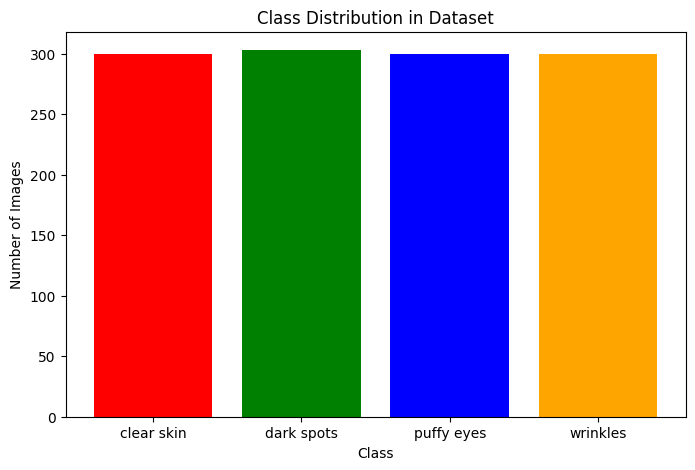

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
colors = ['red', 'green', 'blue', 'orange']  
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.title("Class Distribution in Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [18]:
import cv2
import numpy as np

IMG_SIZE = 224
processed_images = []

for img in data: 
    resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    normalized = resized / 255.0
    processed_images.append(normalized)

processed_images = np.array(processed_images)

print("Processed images shape:", processed_images.shape)


Processed images shape: (1203, 224, 224, 3)


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,     
    width_shift_range=0.1, 
    height_shift_range=0.1,
    zoom_range=0.2,        
    horizontal_flip=True,  
    fill_mode='nearest'
)


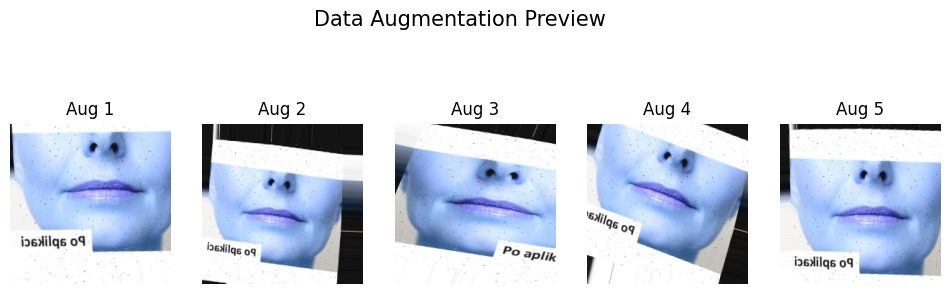

In [20]:
import numpy as np
import random
import matplotlib.pyplot as plt

random_index = random.randrange(len(processed_images))
selected_image = processed_images[random_index]

# Prepare image for augmentation
image_array = np.expand_dims(selected_image, axis=0)

# Generate 5 augmented versions
augmented_batch = [next(datagen.flow(image_array))[0] for _ in range(5)]

# Plot results
plt.figure(figsize=(12, 4))

for i, img in enumerate(augmented_batch):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Aug {i+1}")

plt.suptitle("Data Augmentation Preview", fontsize=15)
plt.show()


In [21]:
print("Unique labels:", set(labels))
print("Classes:", classes)


Unique labels: {'dark spots', 'puffy eyes', 'clear skin', 'wrinkles'}
Classes: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


In [22]:
from tensorflow.keras.utils import to_categorical


label_map = {cls: i for i, cls in enumerate(classes)}
print("Label Mapping:", label_map)


numeric_labels = [label_map[label] for label in labels]


num_classes = len(classes)
labels_one_hot = to_categorical(numeric_labels, num_classes)

print("One-hot encoded shape:", labels_one_hot.shape)
print(labels_one_hot[:5])

Label Mapping: {'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}
One-hot encoded shape: (1203, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [23]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt


In [24]:
# CHANGE ONLY THIS PATH IF NEEDED
DATASET_PATH = r"DATASET-20251202T142134Z-1-001/DATASET"

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
SEED = 123
EPOCHS = 20


In [25]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_ds.class_names
print("Class names:", class_names)


Found 1203 files belonging to 4 classes.
Using 963 files for training.
Found 1203 files belonging to 4 classes.
Using 240 files for validation.
Class names: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [27]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # IMPORTANT for stability


In [28]:
model = models.Sequential([
    base_model,
    layers.Rescaling(1./255),   # normalization INSIDE model
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation="softmax")
])


In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 7, 7, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [30]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.3956 - loss: 1.3837 - val_accuracy: 0.4792 - val_loss: 1.3813
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5369 - loss: 1.3779 - val_accuracy: 0.5458 - val_loss: 1.3767
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6127 - loss: 1.3719 - val_accuracy: 0.5917 - val_loss: 1.3721
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6231 - loss: 1.3667 - val_accuracy: 0.6042 - val_loss: 1.3677
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6636 - loss: 1.3610 - val_accuracy: 0.6458 - val_loss: 1.3628
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6729 - loss: 1.3555 - val_accuracy: 0.6667 - val_loss: 1.3580
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7113 - loss: 1.3501 - val_accuracy: 0.6750 - val_loss: 1.3531
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7092 - loss: 1.3447 - val_accuracy: 0.6833 - val_loss:

In [31]:
final_train_acc = history.history["accuracy"][-1] * 100
final_val_acc = history.history["val_accuracy"][-1] * 100

print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")


Final Training Accuracy: 76.01%
Final Validation Accuracy: 75.00%


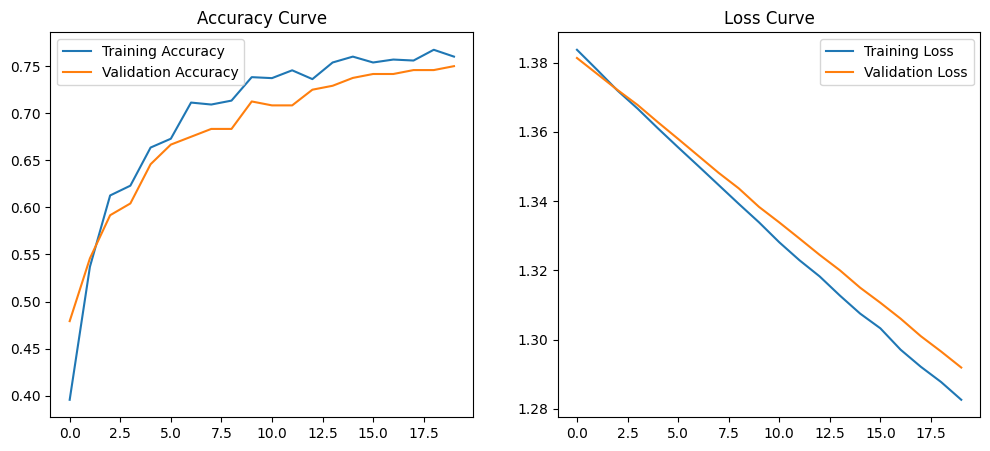

In [44]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curve")

plt.show()


In [49]:
model.save("EfficientNetB0_SkinAging_Model.keras")
print(" Model saved successfully!")


 Model saved successfully!


In [323]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:

DATASET_ROOT = r"DATASET-20251202T142134Z-1-001/DATASET"


CLASS_NAMES = ["clear skin", "dark spots", "puffy eyes", "wrinkles"]

IMG_SIZE = 224


In [325]:
model = tf.keras.models.load_model("EfficientNetB0_SkinAging_Model.keras")
print("Model loaded successfully")


Model loaded successfully


In [326]:
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


In [327]:
def preprocess_face(face_img):
    face_img = cv2.resize(face_img, (IMG_SIZE, IMG_SIZE))
    face_img = face_img.astype(np.float32) / 255.0
    return np.expand_dims(face_img, axis=0)


In [328]:
def predict_and_show(image_path):

    img = cv2.imread(image_path)
    if img is None:
        print("❌ Image not found:", image_path)
        return

    original = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(80, 80)
    )

    # --- FACE FOUND ---
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face = img[y:y+h, x:x+w]
        box = (x, y, w, h)

    # --- NO FACE → USE FULL IMAGE ---
    else:
        face = img
        h, w, _ = img.shape
        box = (0, 0, w, h)

    # Prediction
    input_face = preprocess_face(face)
    preds = model.predict(input_face)[0]

    idx = np.argmax(preds)
    label = CLASS_NAMES[idx]
    confidence = preds[idx] * 100

    # Draw GREEN bounding box
    x, y, w, h = box
    cv2.rectangle(original, (x, y), (x+w, y+h), (0, 255, 0), 3)

    # Text on image (SMALL & CLEAR)
    text = f"{label}: {confidence:.2f}%"
    cv2.putText(
        original,
        text,
        (x + 8, y + 25),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 255, 0),
        2
    )

    # Show image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    # Print result BELOW image
    print("✅ Prediction Result")
    print("Skin Problem:", label)
    print(f"Confidence: {confidence:.2f}%")


 Testing image: DATASET-20251202T142134Z-1-001/DATASET\dark spots\c433012d-eaba-4a83-a741-f7b34a94e775.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


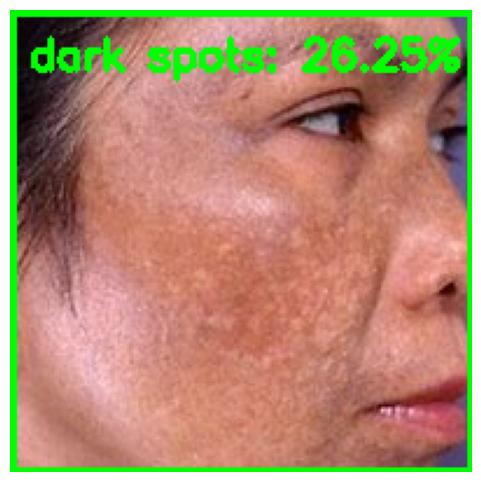

✅ Prediction Result
Skin Problem: dark spots
Confidence: 26.25%


In [331]:
cls = random.choice(CLASS_NAMES)
img_name = random.choice(os.listdir(os.path.join(DATASET_ROOT, cls)))

test_image = os.path.join(DATASET_ROOT, cls, img_name)
print(" Testing image:", test_image)

predict_and_show(test_image)
